# 앙상블 회귀

## (공통) 데이터 로딩 및 분할

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore')

df = pd.read_csv('./datasets/HousingData.csv')

In [15]:
df = df.ffill()

In [16]:
x = df.drop('MEDV', axis =1 )
y = df['MEDV']

x = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=1)

## Voting
- 동일 데이터셋에 대해 서로 다른 회귀모형 알고리즘을 사용하여 각 모델의 예측 결과의 평균값을 반환한다.

### 패키지 로딩

In [17]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import VotingRegressor

### 모델 생성

In [18]:
# L1 규제 : 데이터가 작은 feature는 삭제할 수도 있음
lasso = Lasso(alpha=0.05)
ridge = Ridge(alpha=1)
linear = LinearRegression() # 규제가 적용되지 않음
vo_r = VotingRegressor(estimators=[('Lasso',lasso), ('Ridge', ridge),('Linear', linear)]) # 셋의 평균을 예측값으로 뽑아냄

### 학습 및 평가

In [19]:
vo_r.fit(x_train, y_train)
y_hat = vo_r.predict(x_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score: {r2_score(y_test, y_hat):.3f}')

RMSE: 4.988
R2 Score: 0.748


### 개별 회귀모형 학습결과 비교 

In [20]:
estimators = [('Lasso',lasso), ('Ridge', ridge),('Linear', linear)]

for name, model in estimators:
    model.fit(x_train, y_train)
    y_hat = model.predict(x_test)
    print(f'{name} 모델 RMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
    print(f'{name} 모델 R2 Score: {r2_score(y_test, y_hat):.3f}')
    print('='*30)

Lasso 모델 RMSE: 5.021
Lasso 모델 R2 Score: 0.745
Ridge 모델 RMSE: 4.978
Ridge 모델 R2 Score: 0.749
Linear 모델 RMSE: 4.976
Linear 모델 R2 Score: 0.749


## Boosting

### AdaBoost

#### 패키지 로딩 

In [21]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

#### 모델 생성

In [22]:
ada_r = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=0)

#### 학습 및 평가 

In [23]:
ada_r.fit(x_train, y_train)
y_hat = ada_r.predict(x_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score: {r2_score(y_test, y_hat):.3f}')

RMSE: 3.606
R2 Score: 0.868


### GradientBoost

#### DecisionTreeRegressor를 활용한 그레디언트 부스팅 원리 이해

In [24]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(10)
x_ = np.random.rand(100, 1) - 0.5 # [-0.5, 0.5) 범위 데이터 100x1 모양으로 생성
y_ = 3*x_[:,0]**2 + 0.05 * np.random.randn(100) # y = 3x^2 + noise 

In [25]:
y_[:3]

array([0.27623009, 0.70126328, 0.05048995])

In [26]:
tree_reg1 = DecisionTreeRegressor(max_depth=3, random_state=10)
tree_reg1.fit(x_, y_)

DecisionTreeRegressor(max_depth=3, random_state=10)

- 다음 의사결정 나무 모형이 이전 예측기가 만든 잔여 오차를 학습한다.

In [27]:
y2 = y_ - tree_reg1.predict(x_) # 첫번째 모델에 의해 만들어진 오차 (정답 - 예측값)
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=11)
tree_reg2.fit(x_, y2)

DecisionTreeRegressor(max_depth=3, random_state=11)

In [28]:
y3 = y2 - tree_reg2.predict(x_) # 첫번째 모델에 의해 만들어진 오차 (정답 - 예측값)
tree_reg3 = DecisionTreeRegressor(max_depth=3, random_state=12)
tree_reg3.fit(x_, y3)

DecisionTreeRegressor(max_depth=3, random_state=12)

- 새로운 샘플에 대한 예측을 만들려면 모든 모델의 예측을 더한다. 

In [29]:
# y = 3x^2 + noise
# x = -0.4, y = 0.48 + a
# x = 0.0, a(noise)
# x = 0.5, y = 0.75 + a (이때의 예측값 : 0.67...)
x_new = np.array([[-0.4],[0.],[0.5]]) # 새로운 데이터 3개가 들어옴
result = np.sum(model.predict(x_new) for model in (tree_reg1, tree_reg2, tree_reg3))
print(result) # -0.4 -> 예측값 : 0.484 ... 

[0.48433793 0.02328039 0.67494791]


- 결과 시각화

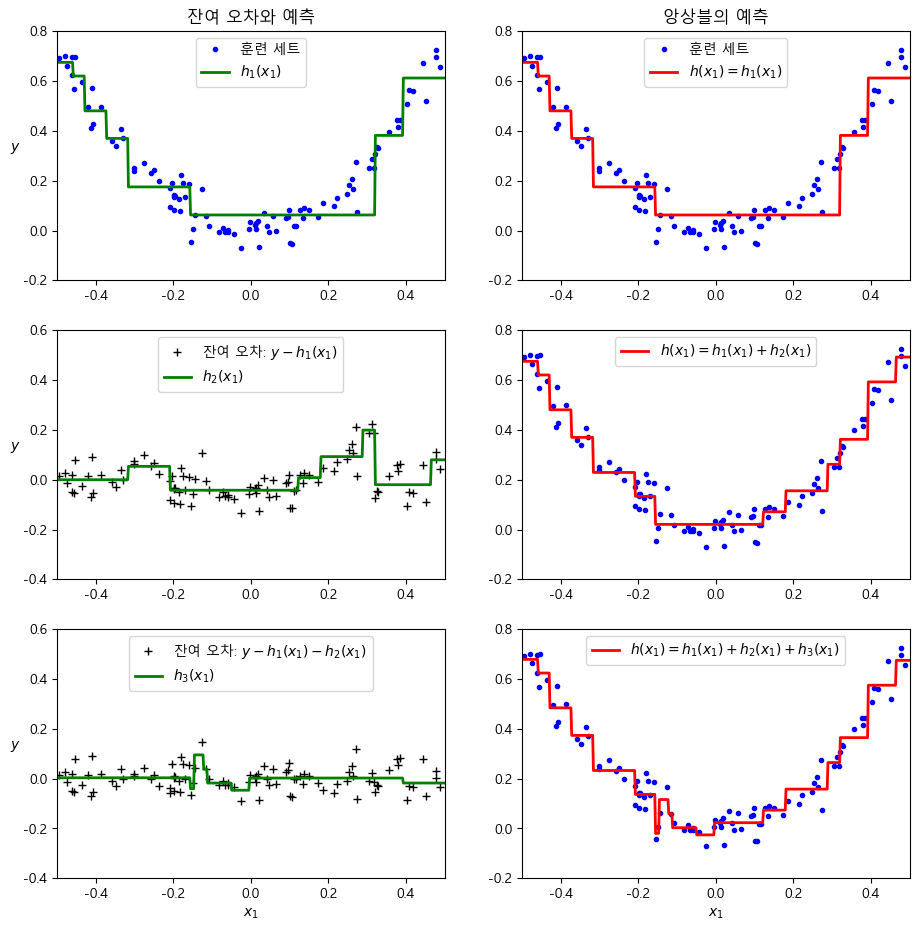

In [30]:
import matplotlib.pyplot as plt
import matplotlib 

matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)    
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$  ", rotation=0)
plt.title("잔여 오차와 예측")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="훈련 세트")
plt.title("앙상블의 예측")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], x_, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], x_, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], x_, y_,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.show()

#### GradientBoostingRegressor와의 비교

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

# learning_rate : 각 트리의 기여 정도 (0.0 ~ inf, default = 1)
# 낮게 설정하면 각 트리의 기여 정도가 낮아져서 훈련 데이터를 학습시키기 위해 많은 트리를 필요로 하게 된다.
gbr1 = GradientBoostingRegressor(max_depth=3, n_estimators=3, learning_rate=1, random_state=10)
gbr1.fit(x_, y_)

GradientBoostingRegressor(learning_rate=1, n_estimators=3, random_state=10)

In [32]:
# n_iter_no_change : 조기 종료(Early Stopping)과 관련된 파라메터
# 지정된 횟수의 반복 동안 더이상 검증 점수 향상이 없으면 학습을 중단한다.
gbr2 = GradientBoostingRegressor(max_depth=3, n_estimators=500, learning_rate=0.05, random_state=11) #, n_iter_no_change=10)
gbr2.fit(x_, y_)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=500, random_state=11)

In [33]:
print(gbr2.n_estimators_)

500


- 결과 시각화

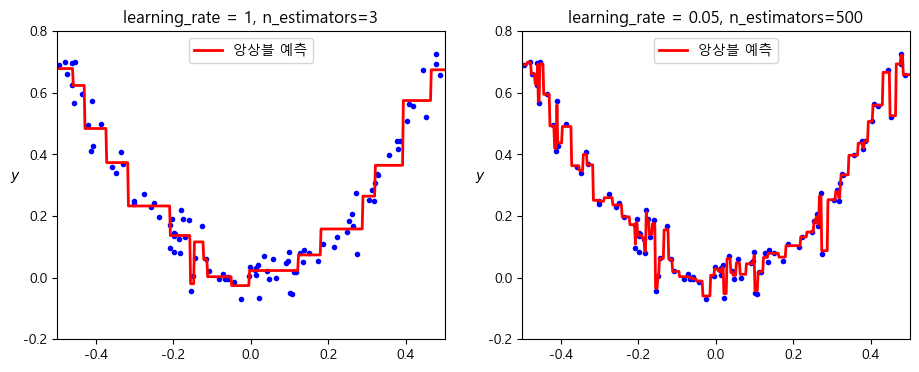

In [34]:
plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
plot_predictions([gbr1], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8], style="r-", label="앙상블 예측")
plt.ylabel("$y$  ", rotation=0)
plt.title(f'learning_rate = {gbr1.learning_rate}, n_estimators={gbr1.n_estimators_}')

plt.subplot(1, 2, 2)
plot_predictions([gbr2], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8], style="r-", label="앙상블 예측")
plt.ylabel("$y$  ", rotation=0)
plt.title(f'learning_rate = {gbr2.learning_rate}, n_estimators={gbr2.n_estimators_}')

plt.show()

#### GradientBoostingRegressor

- 모델 생성 및 학습

In [35]:
gbr = GradientBoostingRegressor(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=300,
    # n_iter_no_change = 10,
    random_state = 10
)
gbr.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=300, random_state=10)

- 모델 평가

In [36]:
y_hat = gbr.predict(x_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score: {r2_score(y_test, y_hat):.3f}')

RMSE: 3.141
R2 Score: 0.900


### XGBoost

In [37]:
!pip install xgboost

#### 파이썬 래퍼 XGBoost

- 패키지 로딩

In [38]:
import xgboost as xgb

- 학습 데이터에서 검증 데이터 분리하기

In [39]:
#x_train, y_train을 분리해서 90%는 학습, 10%는 (매 반복 학습 시 마다) 검증용으로 사용
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state= 10)

- DMatrix : XGBoost 전용 데이터 객체

In [40]:
feature_names = df.drop('MEDV', axis=1).columns
dtrain = xgb.DMatrix(x_train, y_train, feature_names=list(feature_names))
dtest = xgb.DMatrix(x_test, y_test, feature_names=list(feature_names))
dval = xgb.DMatrix(x_val, y_val, feature_names=list(feature_names))

- 모델 생성 및 학습

In [41]:
params = {
    'eval_metric':'rmse', # 성능평가지표
    'objective' : 'reg:squarederror', #손실함수 지정
    'max_depth' : 3, # 의사결정나무의 깊이
    'eta' : 0.1 # 학습율
}

In [42]:
# num_boost_round:나무의 개수(반복학습 수)
# early_stopping_rounds : eval_metric 결과가 early_stopping_rounds 횟수 동안 개선되지 않으면 early_stopping_rounds에 도달하기 전에 조기 종료한다.(evals<성능 평가를 위한 평가용 데이터 셋>과 함께 설정해야 한다.) 
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=500, early_stopping_rounds=10, evals=[(dtrain, 'train'),(dval, 'eval')]) # 첫번째 데이터는 학습, 두번째 데이터는 평가용

[0]	train-rmse:8.45604	eval-rmse:6.77447
[1]	train-rmse:7.81105	eval-rmse:6.33277
[2]	train-rmse:7.22947	eval-rmse:5.93251
[3]	train-rmse:6.72478	eval-rmse:5.64591
[4]	train-rmse:6.25765	eval-rmse:5.31793
[5]	train-rmse:5.85585	eval-rmse:5.10174
[6]	train-rmse:5.49278	eval-rmse:4.91791
[7]	train-rmse:5.12672	eval-rmse:4.68755
[8]	train-rmse:4.83821	eval-rmse:4.52721
[9]	train-rmse:4.54551	eval-rmse:4.36852
[10]	train-rmse:4.28768	eval-rmse:4.19689
[11]	train-rmse:4.05949	eval-rmse:4.08055
[12]	train-rmse:3.85760	eval-rmse:3.95697
[13]	train-rmse:3.67843	eval-rmse:3.85286
[14]	train-rmse:3.51753	eval-rmse:3.74871
[15]	train-rmse:3.36352	eval-rmse:3.68059
[16]	train-rmse:3.23409	eval-rmse:3.61263
[17]	train-rmse:3.11430	eval-rmse:3.56835
[18]	train-rmse:3.01372	eval-rmse:3.50601
[19]	train-rmse:2.92301	eval-rmse:3.45360
[20]	train-rmse:2.83922	eval-rmse:3.42702
[21]	train-rmse:2.76656	eval-rmse:3.39242
[22]	train-rmse:2.69625	eval-rmse:3.35036
[23]	train-rmse:2.63599	eval-rmse:3.34103
[2

- 모델 평가

In [43]:
y_hat = xgb_model.predict(dtest)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score: {r2_score(y_test, y_hat):.3f}')

RMSE: 3.356
R2 Score: 0.886


- Feature Importance 

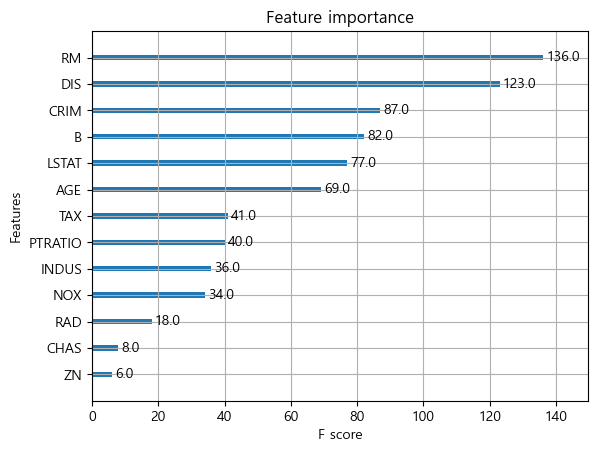

In [44]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model)
plt.show()

#### 사이킷런 래퍼 XGBoost

In [45]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(n_estimators=500, learning_rate = 0.1, max_depth=3)
evals = [(x_train, y_train),(x_val, y_val)]
xgb_reg.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='rmse', eval_set=evals, verbose = True) #verbose : 학습 과정 콘솔 출력 여부

[0]	validation_0-rmse:8.45604	validation_1-rmse:6.77447
[1]	validation_0-rmse:7.81105	validation_1-rmse:6.33277
[2]	validation_0-rmse:7.22947	validation_1-rmse:5.93251
[3]	validation_0-rmse:6.72478	validation_1-rmse:5.64591
[4]	validation_0-rmse:6.25765	validation_1-rmse:5.31793
[5]	validation_0-rmse:5.85585	validation_1-rmse:5.10174
[6]	validation_0-rmse:5.49278	validation_1-rmse:4.91791
[7]	validation_0-rmse:5.12672	validation_1-rmse:4.68755
[8]	validation_0-rmse:4.83821	validation_1-rmse:4.52721
[9]	validation_0-rmse:4.54551	validation_1-rmse:4.36852
[10]	validation_0-rmse:4.28768	validation_1-rmse:4.19689
[11]	validation_0-rmse:4.05949	validation_1-rmse:4.08055
[12]	validation_0-rmse:3.85760	validation_1-rmse:3.95697
[13]	validation_0-rmse:3.67843	validation_1-rmse:3.85286
[14]	validation_0-rmse:3.51753	validation_1-rmse:3.74871
[15]	validation_0-rmse:3.36352	validation_1-rmse:3.68059
[16]	validation_0-rmse:3.23409	validation_1-rmse:3.61263
[17]	validation_0-rmse:3.11430	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
y_hat = xgb_reg.predict(x_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score: {r2_score(y_test, y_hat):.3f}')

RMSE: 3.352
R2 Score: 0.886


### LightGBM (사이킷런 래퍼)

In [47]:
!pip install lightgbm

In [48]:
import lightgbm

In [49]:
from lightgbm import LGBMRegressor, early_stopping

In [50]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=10)

In [51]:
lgbm_reg = LGBMRegressor(n_estimators=500, learning_rate=0.1, max_depth=3)
evals = [(x_train, y_train),(x_val, y_val)]
lgbm_reg.fit(x_train, y_train, eval_metric = 'rmse', callbacks=[early_stopping(stopping_rounds=10)], eval_set=evals) # callbacks : 조기 종료를 위한 함수 이름, 리스트 형태여야 함

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 290, number of used features: 13
[LightGBM] [Info] Start training from score 23.177586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

LGBMRegressor(max_depth=3, n_estimators=500)

In [52]:
y_hat = lgbm_reg.predict(x_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score: {r2_score(y_test, y_hat):.3f}')

RMSE: 3.622
R2 Score: 0.867


# 앙상블 분류

## (공통) 데이터 로딩 및 분할

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer

import numpy as np
import pandas as pd

In [54]:
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
print(df.shape)
display(df.head())
x = df
y = cancer.target

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [55]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0, stratify=y)

## Voting

### 패키지 로딩

In [56]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

### 모델 생성
- voting : hard, soft 값 사용(default : hard)

In [57]:
logistic = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier(n_neighbors=3)
nb = GaussianNB()

vo_c = VotingClassifier(estimators=[('Logistic', logistic),('KNN', knn),('Naive_Bayes', nb)], voting='soft') # soft voting : 각 모델 확률값들의 평균

### 학습 및 평가

In [59]:
vo_c.fit(x_train, y_train)
y_hat = vo_c.predict(x_test)

print(f'정확도: {accuracy_score(y_test, y_hat):.3f}')
print(f'AUC:{roc_auc_score(y_test, vo_c.predict_proba(x_test)[:,1]):.3f}')

정확도: 0.956
AUC:0.988


### 개별 분류모형 학습결과 비교

In [60]:
estimators=[('Logistic', logistic),('KNN', knn),('Naive_Bayes', nb)]

for name, model in estimators:
    model.fit(x_train, y_train)
    y_hat = model.predict(x_test)
    
    print(f'{name} 모델 정확도: {accuracy_score(y_test, y_hat):.3f}')
    print(f'{name} 모델 AUC:{roc_auc_score(y_test, model.predict_proba(x_test)[:,1]):.3f}')
    print('='*40)

Logistic 모델 정확도: 0.947
Logistic 모델 AUC:0.994
KNN 모델 정확도: 0.904
KNN 모델 AUC:0.931
Naive_Bayes 모델 정확도: 0.921
Naive_Bayes 모델 AUC:0.971


## Boosting

### AdaBoost

#### 패키지 로딩

In [61]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#### 모델 생성

In [63]:
boo_c = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), n_estimators = 300, random_state=0)

#### 학습 및 평가

In [64]:
boo_c.fit(x_train, y_train)
y_hat = boo_c.predict(x_test)

print(f'정확도: {accuracy_score(y_test, y_hat):.3f}')
print(f'AUC:{roc_auc_score(y_test, boo_c.predict_proba(x_test)[:,1]):.3f}')

정확도: 0.921
AUC:0.969


### GradientBoost

#### 패키지 로딩

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

#### 모델 생성 및 학습 

In [67]:
gb_c = GradientBoostingClassifier(random_state=0)
gb_c.fit(x_train, y_train)

GradientBoostingClassifier(random_state=0)

#### 예측 및 평가

In [68]:
y_hat = gb_c.predict(x_test)

print(f'정확도: {accuracy_score(y_test, y_hat):.3f}')
print(f'AUC:{roc_auc_score(y_test, gb_c.predict_proba(x_test)[:,1]):.3f}')

정확도: 0.939
AUC:0.983


#### 하이퍼 파라메터 튜닝 

In [69]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [200, 300],
    'max_depth' : [3,6,8],
    'min_samples_split' : [2, 3, 5, 10], # 샘플 수가 적을수록 나무의 깊이가 깊어짐
    'learning_rate' : [0.05, 0.1, 0.2]
}

gb_grid = GridSearchCV(gb_c, params, cv = 5, scoring='accuracy', n_jobs=-1)
gb_grid.fit(x, y)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 6, 8],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [200, 300]},
             scoring='accuracy')

In [70]:
print(f'최적 파라메터 : {gb_grid.best_params_}')
print(f'평균 정확도 : {gb_grid.best_score_}')

최적 파라메터 : {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}
평균 정확도 : 0.9666200900481291


In [71]:
estimators = gb_grid.best_estimator_
y_hat = estimators.predict(x_test)

print(f'정확도: {accuracy_score(y_test, y_hat):.3f}')
print(f'AUC:{roc_auc_score(y_test, estimators.predict_proba(x_test)[:,1]):.3f}')

정확도: 1.000
AUC:1.000


### XGBoost (사이킷런 래퍼)

In [72]:
# 학습 데이터로부터 10%의 검증용 데이터를 분리
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, stratify=y_train)

In [73]:
from xgboost import XGBClassifier

xgb_c = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=3)
evals = [(x_train, y_train), (x_val, y_val)]
# logloss : 분류 문제에 사용되는 손실 함수, cross-entropy error라고도 한다. 
xgb_c.fit(x_train, y_train, early_stopping_rounds=10, eval_metric = 'logloss', eval_set = evals, verbose =True)

[0]	validation_0-logloss:0.61963	validation_1-logloss:0.61936
[1]	validation_0-logloss:0.58231	validation_1-logloss:0.58398
[2]	validation_0-logloss:0.54854	validation_1-logloss:0.55207
[3]	validation_0-logloss:0.51704	validation_1-logloss:0.51922
[4]	validation_0-logloss:0.48742	validation_1-logloss:0.48863
[5]	validation_0-logloss:0.46068	validation_1-logloss:0.46463
[6]	validation_0-logloss:0.43558	validation_1-logloss:0.43867
[7]	validation_0-logloss:0.41205	validation_1-logloss:0.41542
[8]	validation_0-logloss:0.39031	validation_1-logloss:0.39330
[9]	validation_0-logloss:0.37084	validation_1-logloss:0.37313
[10]	validation_0-logloss:0.35201	validation_1-logloss:0.35400
[11]	validation_0-logloss:0.33482	validation_1-logloss:0.33474
[12]	validation_0-logloss:0.31944	validation_1-logloss:0.32149
[13]	validation_0-logloss:0.30435	validation_1-logloss:0.30451
[14]	validation_0-logloss:0.28998	validation_1-logloss:0.28979
[15]	validation_0-logloss:0.27671	validation_1-logloss:0.27483
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [74]:
y_hat = xgb_c.predict(x_test)

print(f'정확도: {accuracy_score(y_test, y_hat):.3f}')
print(f'AUC:{roc_auc_score(y_test, xgb_c.predict_proba(x_test)[:,1]):.3f}')

정확도: 0.947
AUC:0.979


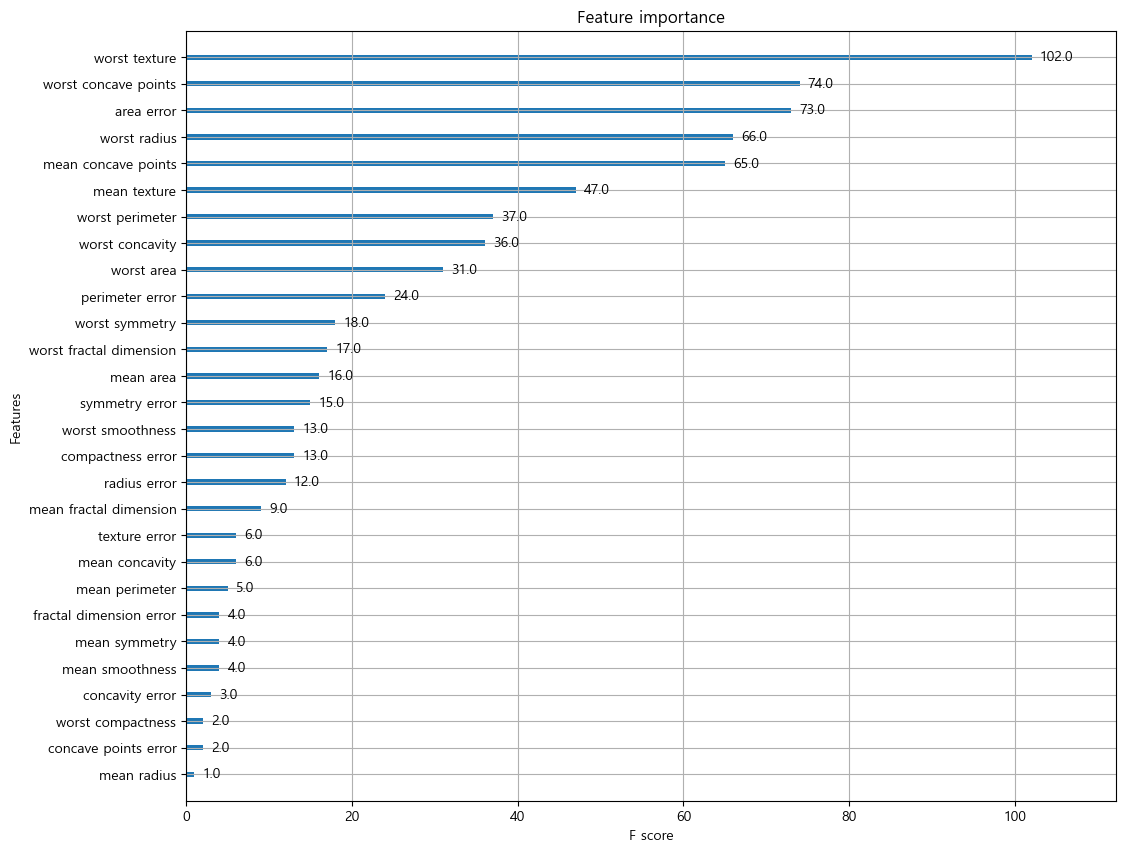

In [77]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(12,10))
plot_importance(xgb_c, ax=ax)
plt.show()

### LightGBM (사이킷런 래퍼)

In [78]:
from lightgbm import LGBMClassifier, early_stopping
lgbm_c = LGBMClassifier(n_estimators=300, learning_rate=0.05)
evals = [(x_train, y_train), (x_val, y_val)]
callbacks = [early_stopping(stopping_rounds=10)]
lgbm_c.fit(x_train, y_train, eval_metric='logloss', callbacks=callbacks, eval_set=evals)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 256, number of negative: 153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625917 -> initscore=0.514740
[LightGBM] [Info] Start training from score 0.514740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(learning_rate=0.05, n_estimators=300)

In [81]:
y_hat = lgbm_c.predict(x_test)

print(f'정확도: {accuracy_score(y_test, y_hat):.3f}')
print(f'AUC:{roc_auc_score(y_test, lgbm_c.predict_proba(x_test)[:,1]):.3f}')

정확도: 0.947
AUC:0.977


## Stacking

### 패키지 로딩

In [82]:
# 1st model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# 2nd meta model 
from sklearn.linear_model import LogisticRegression 

### 모델 생성

In [84]:
knn_1st = KNeighborsClassifier(n_neighbors=3)
rf_1st = RandomForestClassifier(random_state=0)
dt_1st = DecisionTreeClassifier() # 하나의 의사결정 나무
ada_1st = AdaBoostClassifier(n_estimators=200)

lr_final = LogisticRegression()

### 학습 및 평가

In [86]:
knn_1st.fit(x_train, y_train)
rf_1st.fit(x_train, y_train)
dt_1st.fit(x_train, y_train)
ada_1st.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=200)

In [87]:
knn_pred = knn_1st.predict(x_test)
rf_pred = rf_1st.predict(x_test)
dt_pred = dt_1st.predict(x_test)
ada_pred = ada_1st.predict(x_test)

### 스태킹(Stacking)

In [90]:
print(knn_pred.shape)
y_hat = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(y_hat.shape)
y_hat = np.transpose(y_hat) # transpose : 열과 행 위치 바꿈 
print(y_hat.shape)

(114,)
(4, 114)
(114, 4)


### 메타 모델 학습 및 평가

In [91]:
lr_final.fit(y_hat, y_test)
final_y_hat = lr_final.predict(y_hat)
print(f'최종 메타 모델의 예측 정확도 : {accuracy_score(y_test, final_y_hat):.3f}')

최종 메타 모델의 예측 정확도 : 0.974
